# Data Cleaning Notebook

## Objectives

*   Evaluate missing data
*   Combine house size variables
*   Clean data

## Inputs

* outputs/datasets/collection/HeritageHousing.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## Conclusions

 
  * Cleaned Data Pipeline

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues-P5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues-P5'

# Load Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HeritageHousing.csv")
    )
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Predictive Power Score and Correlation Study

Let's run some more analysis on the data before we continue, so we can look at how the missing data correlates with the rest of our data set.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.show()



def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [6]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702






*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



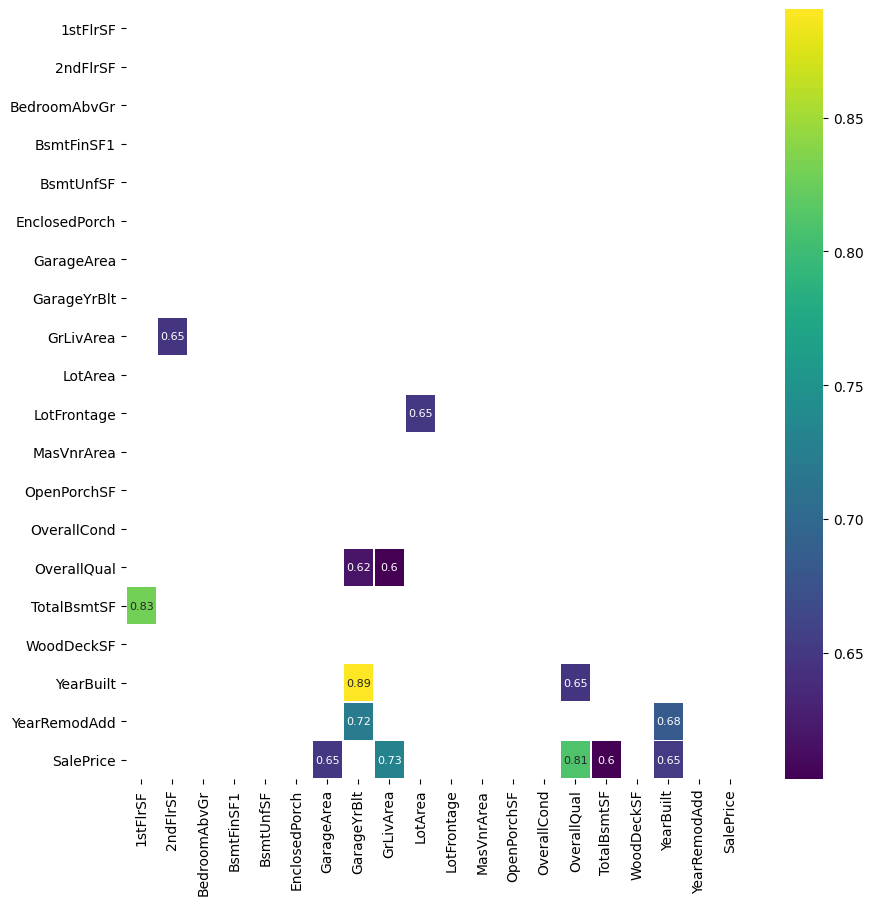



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



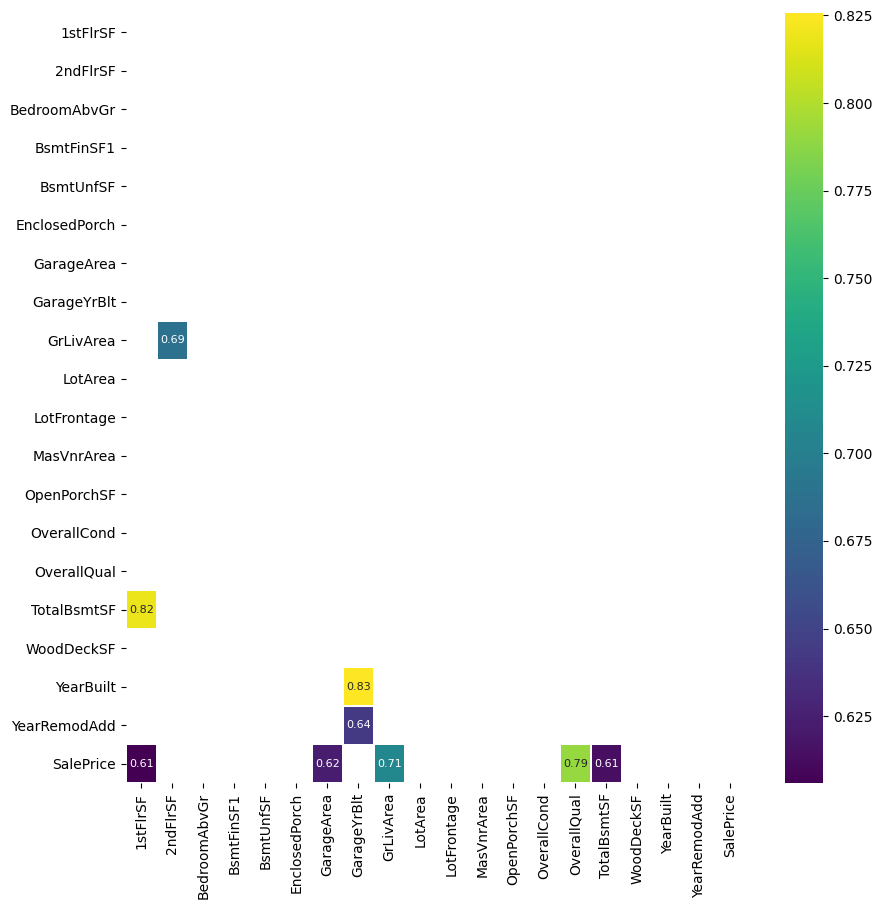



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.



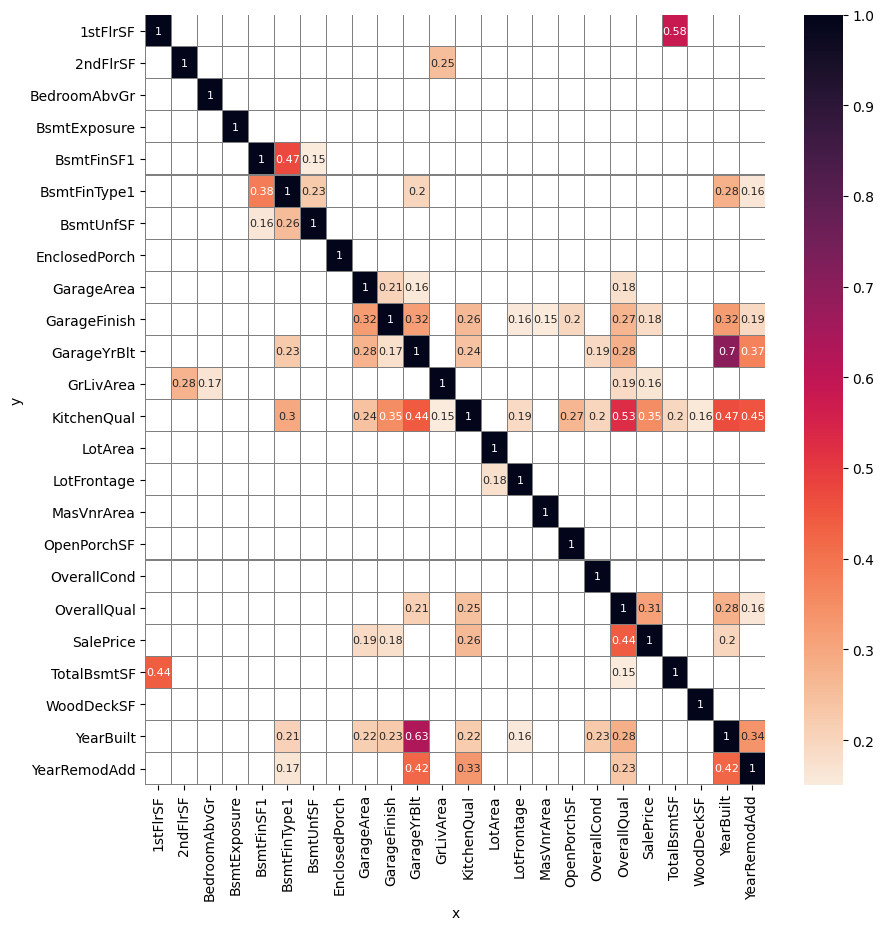

In [7]:
DisplayCorrAndPPS(df_corr_pearson=df_corr_pearson,
                  df_corr_spearman=df_corr_spearman, 
                  pps_matrix=pps_matrix,
                  CorrThreshold=0.6, PPS_Threshold=0.15,
                  figsize=(10,10), font_annot=8)

---

## Missing Data

Let's remind ourselves of the columns that have missing data.

In [9]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

Now we can discuss what changes we want to make to each of the variables and their missing data.

First we will want to use an ArbitraryNumberImputer function to replace the missing data of `2ndFlrSF`, `EnclosedPorch`, `MasVnrArea` and `WoodDeckSF` with 0 as it is the most common value for all of these variables. It's safer to assume that a missing value for these variables means that the house simply doesn't have one of those features. For example, `EnclosedPorch` is missing 90.7% and 7.9% of the data that we do have is 0 meaning that for more than 80% of the data that we do have the value is 0.

In most cases it's fine to drop columns that are missing 80% or more of their data. But we know that a houses size is one of the greatest predictors of Sale Price and want to see if we can gain a better PPS by combining all the variables related to the houses size once the data is cleaned.

The other variable related to the size of the house is `LotFrontage`. With the pandas profile report in the last notebook, we can see that this data is much closer to being normally distributed and so, we will use the MeanMedianImputer function to impute the NaN values with a median value.

---

Next is `Bedroom Above Grade`. We don't know what the 'grade' is and this column isn't missing too much data so we'll drop any of the rows missing this variable. Perhaps with more understanding of what the variable is, we could estimate the number of Bedrooms above grade based on other houses vs their overall size and perhaps quality. 

---

Then there are two columns of missing data for the garages. Let's take one more look at them, along with `YearBuilt` and `GarageArea`.

In [10]:
df_nan_finish = df[df['GarageFinish'].isna()]
df_nan_finish[['GarageFinish','GarageYrBlt', 'GarageArea', 'YearBuilt']]

,GarageFinish,GarageYrBlt,GarageArea,YearBuilt
7,NaN,1973.0,484,1973
12,NaN,1962.0,352,1962
23,NaN,1976.0,572,1976
27,NaN,2008.0,772,2007
35,NaN,2004.0,691,2004
...,...,...,...,...
1401,NaN,2004.0,398,2004
1415,NaN,2007.0,660,2007
1438,NaN,1957.0,923,1957
1442,NaN,2008.0,812,2008


In [11]:

df_nan_year = df[df['GarageYrBlt'].isna()]
df_nan_year[['GarageFinish','GarageYrBlt', 'GarageArea']]

,GarageFinish,GarageYrBlt,GarageArea
39,None,NaN,0
48,None,NaN,0
78,None,NaN,0
88,None,NaN,0
89,None,NaN,0
...,...,...,...
1349,None,NaN,0
1407,None,NaN,0
1449,None,NaN,0
1450,None,NaN,0


There doesn't seem to be any clear indicator of what the best way to set the `GarageFinish` as would be. 
It also showed little to no correlation against the sale price in our initial study of the data we can fill the missing data with `Unf` unless the GarageArea is 0 in which case we fill it with `None`.
Using the PPS we see there is moderate correlation between `GarageFinish`, `Overall Quality`, `YearBuilt` and others. So in future we could perhaps predict what `GarageFinish` should be based on other variables to improve our model. But for now we're happy to use the frequent category as our imputation method by using the CategoricalVariableImputer function. 

---

We'll use the same reasoning and imputation method as `GarageFinish` for `BsmtFinType1`, using `Unf` for any missing data and `None` for any missing where the `TotalBsmtSF` is 0. 

---

And for `GarageYrBlt` we can see the NaN values are appearing where a house doesn't have a garage. 
We can't set this value to 0 but there's a clear indication that most houses are built with a garage as they typically have the same `YearBuilt` and `GarageYrBlt` dates.
So for this we'll replace any missing values with the date the year the house was built.

![DataCleaningSpreadsheet](../media/DataCleaning.png)

As we clean the data, we will use a number of functions built by feature-engine to perform the imputation and then plot the original and cleaned datasets to visualise the effect our changes have on the data.

In [ ]:
# MeanMedianImputer

import feature_engine.missing_data_imputers as mdi

# Load dataset
data = pd.read_csv('houseprice.csv')

# Separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
data.drop(['Id', 'SalePrice'], axis=1), data['SalePrice'], test_size=0.3, random_state=0)

# set up the imputer
median_imputer = mdi.MeanMedianImputer(imputation_method='median',
                                       variables=['LotFrontage', 'MasVnrArea'])
# fit the imputer
median_imputer.fit(X_train)

# transform the data
train_t= median_imputer.transform(X_train)
test_t= median_imputer.transform(X_test)

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [ ]:
# ArbitraryNumberImputer

# Load dataset
data = pd.read_csv('houseprice.csv')

# Separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
data.drop(['Id', 'SalePrice'], axis=1), data['SalePrice'], test_size=0.3, random_state=0)

# set up the imputer
arbitrary_imputer = mdi.ArbitraryNumberImputer(
arbitrary_number=-999, variables=['LotFrontage', 'MasVnrArea'])

# fit the imputer
arbitrary_imputer.fit(X_train)

# transform the data
train_t= arbitrary_imputer.transform(X_train)
test_t= arbitrary_imputer.transform(X_test)

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [ ]:
# CatagoricalVariableImputer

# Load dataset
data = pd.read_csv('houseprice.csv')

# Separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
data.drop(['Id', 'SalePrice'], axis=1), data['SalePrice'], test_size=0.3, random_state=0)

# set up the imputer
imputer = mdi.CategoricalVariableImputer(variables=['Alley', 'MasVnrType'])

# fit the imputer
imputer.fit(X_train)

# transform the data
train_t= imputer.transform(X_train)
test_t= imputer.transform(X_test)

test_t['MasVnrType'].value_counts().plot.bar()

In [16]:
variables_method = ['2ndFlrSF']
variables_method

['2ndFlrSF']

In [ ]:
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
df_method = imputer.fit_transform(df)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF'] 




ValueError: Could not interpret value `2ndFlrSF` for parameter `x`

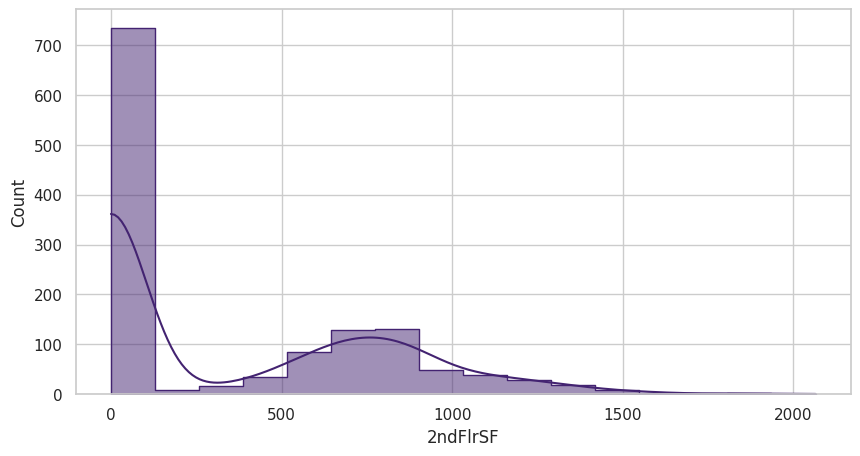

In [17]:
variables_method = ['2ndFlrSF']
df_method = df['2ndFlrSF'].fillna(0)
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

In [ ]:
df['2ndFlrSF'].fillna(0, inplace=True)
df['EnclosedPorch'].fillna(0, inplace=True)
df['LotFrontage'].fillna(0, inplace=True)
df['MasVnrArea'].fillna(0, inplace=True)
df['WoodDeckSF'].fillna(0, inplace=True)
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

In [ ]:
df['BedroomAbvGr'].isnull().sum()

In [13]:
df.dropna(subset=['BedroomAbvGr'], inplace=True)
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [ ]:
df_nan_finish = df[df['GarageFinish'].isna()]
df_nan_finish[['GarageFinish','GarageYrBlt', 'GarageArea', 'YearBuilt']]

df_nan_year = df[df['GarageYrBlt'].isna()]
df_nan_year[['GarageFinish','GarageYrBlt', 'GarageArea']]

In [ ]:
df['BsmtFinType1'].value_counts()

We know from our initial study of the data that this variable shows between negative low to positive low correlation against the sale price of a house and isn't important. So we can confiedently fill in the missing values as Unf.


In [ ]:
df['BsmtFinType1'].fillna(value='Unf', inplace=True)
df['BsmtFinType1'].value_counts()

In [ ]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

From the PPS and Pearson and Spearman correlations, as hypothesized, we see a very strong correlation between GarageYrBlt and YearBuilt so we can fill in the missing values of the garage year built with the year the house was built.

In [ ]:
df['GarageYrBlt'].fillna(df['YearBuilt'], inplace=True)
df[['YearBuilt', 'GarageYrBlt']]

---

NOTE

* You may add how many sections you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section for "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
